# KADEM Hocine
# BENAHMED Neil

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video
import torch.nn as nn
import gymnasium as gym
from bbrl.utils.chrono import Chrono
import matplotlib
import matplotlib.pyplot as plt
from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial
import tools 
matplotlib.use("TkAgg")
import gymnasium as gym
import tools
from scipy.stats import ttest_ind

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)

Matplotlib backend: module://matplotlib_inline.backend_inline


# Naive actor critic algorithm Function

In [3]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm with entropy and convergence tracking.
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories, entropies, convergence_steps
    """
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []
    entropies = []  # List to track entropy
    convergence_steps = 0

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False
        entropy_episode = 0

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            a = sample_categorical(pi[s, :])
            s_next, r, terminated, truncated, _ = env.step(a)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]
            V[s] = V[s] + alpha_critic * delta

            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Calculate entropy for current state
            entropy_episode += -np.sum(pi[s, :] * np.log(pi[s, :] + 1e-8))

            s = s_next
            cpt += 1

        trajectories.append(cpt)
        entropies.append(entropy_episode)  # Store entropy for this episode

        # Check for convergence (e.g., policy does not change significantly)
        if episode > 1 and np.allclose(pi, previous_pi, atol=1e-3):
            convergence_steps = episode
            break

        previous_pi = pi.copy()

    return pi, V, trajectories, entropies, convergence_steps


### Actor-critic hyper-parameters

In [4]:
# Define global constants 
NB_EPISODES = 400

AC_PARAMS = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human",  # "human" to render the maze OR "rgb_array"
    },
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",
    "nb_episodes": NB_EPISODES,
    "timeout": 200,
    "render": True,
    "nb_repeats": 5,
    "gamma": 0.9,
    
    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

# # Base actor-critic parameters
# AC_PARAMS = {
#     'nb_episodes': NB_EPISODES,
#     'timeout': 50,
#     'gamma': 0.99,
#     'mdp': {
#         'width': 5,
#         'height': 5,
#         'ratio': 0.2,
#         'render_mode': "humain",
#     },
#     "alpha_critic": 0.5,
#     "alpha_actor": 0.5,
# }

### Run multiple experiments

In [5]:
AC_PARAMS['mdp']['render_mode'] = "human"
env = tools.create_maze_from_params(AC_PARAMS)

alpha_actor = AC_PARAMS['alpha_actor']
alpha_critic = AC_PARAMS['alpha_critic']
gamma = AC_PARAMS['alpha_critic'] 
nb_episodes = AC_PARAMS['nb_episodes']
timeout = AC_PARAMS['timeout']
 

pi, V_per_episode, trajectories, entropies, rewards_per_episode, deltas = tools.naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=True
        )

/home/neil/dac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.
  logger.warn(
/home/neil/dac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_v_pi to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.draw_v_pi` for environment variables or `env.get_wrapper_attr('draw_v_pi')` that will search the reminding wrappers.
  logger.warn(


       [-1,  4,  9, 13, 16],
       [-1,  5, 10, …

In [6]:
%matplotlib inline
AC_PARAMS['mdp']["render_mode"] = "rgb_array"
n_runs = 5
# Run multiple experiments and gather results
all_values, all_trajectories, all_entropies, all_rewards, all_deltas = tools.run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

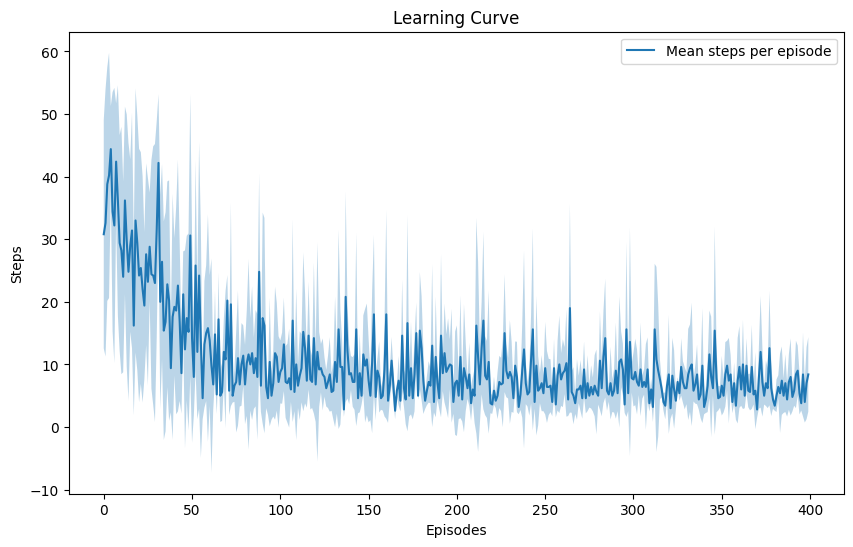

In [7]:
def plot_learning_curve(all_trajectories, plot_name=''):
    # Calculate mean and std for trajectories, assuming they are of different lengths
    max_len = max(map(len, all_trajectories))
    
    # Convert trajectories to arrays of floats and pad with NaN
    padded_trajectories = np.array([np.pad(np.array(t, dtype=float), (0, max_len - len(t)), 'constant', constant_values=np.nan) for t in all_trajectories])
    
    # Calculate mean and std, ignoring NaNs
    mean_trajectories = np.nanmean(padded_trajectories, axis=0)
    std_trajectories = np.nanstd(padded_trajectories, axis=0)
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(mean_trajectories, label='Mean steps per episode')
    plt.fill_between(range(len(mean_trajectories)), mean_trajectories - std_trajectories, mean_trajectories + std_trajectories, alpha=0.3)
    plt.xlabel('Episodes')
    plt.ylabel('Steps')
    plt.title(plot_name)
    plt.legend()
    plt.show()

# Plot the learning curve with the updated function
plot_learning_curve(all_trajectories,'Learning Curve')

# Perform hyper-parameters tuning

## Set up the basic parameters and optimization criteria

In this first step, we define the base parameters for the optimization process, such as the search space for alpha_actor and alpha_critic, the samplers (search strategies), and store the optimization results.

In [8]:
# Total number of trials and the number of values for each hyperparameter
n_trials = 300  # Chosen for sufficient exploration of the search space

# The number of independent runs per trial to average results and reduce variability.
n_runs = 3  # Ensures stability of results across multiple runs

# The number of episodes per trial
nb_episodes = 400  # Chosen for enough training time per trial

In [9]:
from optuna.samplers import TPESampler, RandomSampler, NSGAIISampler, GridSampler

n_values = int(np.sqrt(n_trials))  # Ensure that the number of values matches the total number of trials

# Search space for alpha_actor and alpha_critic (logarithmic scale)
SEARCH_SPACE = {
    "alpha_actor": np.logspace(-1, 0, n_values).tolist(),  # From 1e-3 to 1.0 with n_values points
    "alpha_critic": np.logspace(-1, 0, n_values).tolist()  # Same range for alpha_critic
}

# List of samplers to evaluate
SAMPLERS = {
    "Grid Search": GridSampler(SEARCH_SPACE),
    "Random Search": RandomSampler(),
    "TPE (Bayesian Optimization)": TPESampler(),
    "NSGA-II": NSGAIISampler()
}

# Dictionary to store the results
results = {}

# Base actor-critic parameters
AC_PARAMS = {
    'nb_episodes': nb_episodes,
    'timeout': 50,
    'gamma': 0.8,
    'mdp': {
        'width': 5,
        'height': 5,
        'ratio': 0.2,
        'render_mode': None
    }
}

## Define the optimization loop for each criterion

In [10]:
# Define the optimization criteria
criteria = ['value_norm', 'convergence_time', 'cumulative_reward', 'discounted_cumulative_reward', 'temporal_difference_error']  

# Loop through each criterion
for criterion in criteria:
    print(f"Optimizing for criterion: {criterion}...")

    # For each criterion, we will loop through the samplers
    for sampler_name, sampler in SAMPLERS.items():
        print(f"Running optimization with {sampler_name}...")

        # Run optimization using the current criterion
        study, best_params, best_performance, all_params, value_norms, trajectories, cumulative_rewards, deltas = tools.run_optimization(
            ac_params=AC_PARAMS,
            sampler=sampler,
            n_trials=n_trials,  
            n_runs=n_runs, 
            criterion=criterion  # Optimization based on the selected criterion
        )

        # Store the results for each sampler
        results[f"{criterion}_{sampler_name}"] = {
            "study": study,
            "best_params": best_params,
            "best_performance": best_performance,
            "all_params": all_params,
            "value_norms": value_norms,
            "trajectories": trajectories,
            "cumulative_rewards": cumulative_rewards,
            "temporal_difference_error" : deltas
        }

        print(f"Best performance for {criterion} using {sampler_name}: {best_performance}")

[I 2024-10-04 21:36:36,053] A new study created in memory with name: no-name-f70d2762-9706-4715-b8cd-fa455443c2c7


Optimizing for criterion: value_norm...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 21:36:36,354] Trial 0 finished with value: -5.954307546020182 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: -5.954307546020182.
[I 2024-10-04 21:36:36,524] Trial 1 finished with value: -6.9699070002453825 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -6.9699070002453825.
[I 2024-10-04 21:36:36,693] Trial 2 finished with value: -7.084111617231864 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 2 with value: -7.084111617231864.
[I 2024-10-04 21:36:36,889] Trial 3 finished with value: -6.325428961474794 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 2 with value: -7.084111617231864.
[I 2024-10-04 21:36:37,135] Trial 4 finished with value: -6.570384967593007 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0

Best performance for value_norm using Grid Search: -7.394279064511759
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 21:37:43,300] Trial 1 finished with value: -6.687848320732648 and parameters: {'alpha_actor': 0.7565963069669197, 'alpha_critic': 0.28953166462108826}. Best is trial 1 with value: -6.687848320732648.
[I 2024-10-04 21:37:43,461] Trial 2 finished with value: -6.806892832719724 and parameters: {'alpha_actor': 0.8327012575178242, 'alpha_critic': 0.8510310060902025}. Best is trial 2 with value: -6.806892832719724.
[I 2024-10-04 21:37:43,805] Trial 3 finished with value: -5.692628015827051 and parameters: {'alpha_actor': 0.31567208931403234, 'alpha_critic': 0.3813574788166336}. Best is trial 2 with value: -6.806892832719724.
[I 2024-10-04 21:37:43,965] Trial 4 finished with value: -6.467349292593692 and parameters: {'alpha_actor': 0.7474607073857806, 'alpha_critic': 0.8130449394154303}. Best is trial 2 with value: -6.806892832719724.
[I 2024-10-04 21:37:44,130] Trial 5 finished with value: -6.823959316440233 and parameters: {'alpha_actor': 0.7042178443355848, 'alpha_critic': 0.

Best performance for value_norm using Random Search: -7.478390571544552
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 21:38:42,320] Trial 1 finished with value: -6.298559188404295 and parameters: {'alpha_actor': 0.9799216037695809, 'alpha_critic': 0.9263125655478304}. Best is trial 0 with value: -7.057900923359289.
[I 2024-10-04 21:38:42,503] Trial 2 finished with value: -6.09391658252359 and parameters: {'alpha_actor': 0.8056125043226184, 'alpha_critic': 0.47856606615334885}. Best is trial 0 with value: -7.057900923359289.
[I 2024-10-04 21:38:42,696] Trial 3 finished with value: -6.577358182563559 and parameters: {'alpha_actor': 0.38092148274816207, 'alpha_critic': 0.9224623969478016}. Best is trial 0 with value: -7.057900923359289.
[I 2024-10-04 21:38:42,918] Trial 4 finished with value: -6.984383604223888 and parameters: {'alpha_actor': 0.12791671702855267, 'alpha_critic': 0.6696182064925764}. Best is trial 0 with value: -7.057900923359289.
[I 2024-10-04 21:38:43,116] Trial 5 finished with value: -6.234601581398539 and parameters: {'alpha_actor': 0.8914415086639494, 'alpha_critic': 0.

Best performance for value_norm using TPE (Bayesian Optimization): -7.489879823107557
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 21:39:40,925] Trial 0 finished with value: -5.813322900438699 and parameters: {'alpha_actor': 0.435139522518843, 'alpha_critic': 0.5219526238348413}. Best is trial 0 with value: -5.813322900438699.
[I 2024-10-04 21:39:41,086] Trial 1 finished with value: -6.949361858554298 and parameters: {'alpha_actor': 0.8809847671737423, 'alpha_critic': 0.9442776662640113}. Best is trial 1 with value: -6.949361858554298.
[I 2024-10-04 21:39:41,274] Trial 2 finished with value: -6.714875102641308 and parameters: {'alpha_actor': 0.3530251313405556, 'alpha_critic': 0.8032380335688669}. Best is trial 1 with value: -6.949361858554298.
[I 2024-10-04 21:39:41,561] Trial 3 finished with value: -5.570504018882748 and parameters: {'alpha_actor': 0.8414596421291056, 'alpha_critic': 0.19916015326656078}. Best is trial 1 with value: -6.949361858554298.
[I 2024-10-04 21:39:41,826] Trial 4 finished with value: -6.233087086723688 and parameters: {'alpha_actor': 0.2127899819615537, 'alpha_critic': 0.45

Best performance for value_norm using NSGA-II: -7.486447028567327
Optimizing for criterion: convergence_time...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 21:40:41,240] Trial 0 finished with value: 25.75333333333333 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: 25.75333333333333.
[I 2024-10-04 21:40:41,399] Trial 1 finished with value: 6.714166666666667 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: 6.714166666666667.
[I 2024-10-04 21:40:41,632] Trial 2 finished with value: 9.87 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: 6.714166666666667.
[I 2024-10-04 21:40:41,822] Trial 3 finished with value: 8.294166666666667 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: 6.714166666666667.
[I 2024-10-04 21:40:41,994] Trial 4 finished with value: 7.159166666666668 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0.23713737056616552}. Bes

Best performance for convergence_time using Grid Search: 5.469166666666667
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 21:41:50,193] Trial 1 finished with value: 10.3425 and parameters: {'alpha_actor': 0.602752775102658, 'alpha_critic': 0.41438732001157974}. Best is trial 0 with value: 8.23.
[I 2024-10-04 21:41:50,367] Trial 2 finished with value: 7.598333333333334 and parameters: {'alpha_actor': 0.7786369298229981, 'alpha_critic': 0.5384560020976249}. Best is trial 2 with value: 7.598333333333334.
[I 2024-10-04 21:41:50,530] Trial 3 finished with value: 7.0475 and parameters: {'alpha_actor': 0.5803239477755229, 'alpha_critic': 0.575236662981551}. Best is trial 3 with value: 7.0475.
[I 2024-10-04 21:41:50,822] Trial 4 finished with value: 13.523333333333333 and parameters: {'alpha_actor': 0.4771778339493131, 'alpha_critic': 0.24434877658858017}. Best is trial 3 with value: 7.0475.
[I 2024-10-04 21:41:51,082] Trial 5 finished with value: 12.521666666666665 and parameters: {'alpha_actor': 0.15592618770285743, 'alpha_critic': 0.9527333918952855}. Best is trial 3 with value: 7.0475.
[I 2024-1

Best performance for convergence_time using Random Search: 5.405
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 21:42:48,935] Trial 0 finished with value: 11.876666666666665 and parameters: {'alpha_actor': 0.17027769513834257, 'alpha_critic': 0.41644244746497494}. Best is trial 0 with value: 11.876666666666665.
[I 2024-10-04 21:42:49,095] Trial 1 finished with value: 6.746666666666666 and parameters: {'alpha_actor': 0.743684097348595, 'alpha_critic': 0.8775576177320747}. Best is trial 1 with value: 6.746666666666666.
[I 2024-10-04 21:42:49,267] Trial 2 finished with value: 6.983333333333333 and parameters: {'alpha_actor': 0.43320998853148385, 'alpha_critic': 0.8916750830740737}. Best is trial 1 with value: 6.746666666666666.
[I 2024-10-04 21:42:49,440] Trial 3 finished with value: 7.1925 and parameters: {'alpha_actor': 0.45913143779612486, 'alpha_critic': 0.6415754181633334}. Best is trial 1 with value: 6.746666666666666.
[I 2024-10-04 21:42:49,690] Trial 4 finished with value: 11.371666666666664 and parameters: {'alpha_actor': 0.4028149869078139, 'alpha_critic': 0.2324479042846276

Best performance for convergence_time using TPE (Bayesian Optimization): 4.923333333333333
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 21:43:43,278] Trial 1 finished with value: 9.255833333333335 and parameters: {'alpha_actor': 0.4509384903916793, 'alpha_critic': 0.9680621119988029}. Best is trial 0 with value: 8.288333333333334.
[I 2024-10-04 21:43:43,570] Trial 2 finished with value: 13.675833333333335 and parameters: {'alpha_actor': 0.9845861588649801, 'alpha_critic': 0.6926204050371909}. Best is trial 0 with value: 8.288333333333334.
[I 2024-10-04 21:43:43,802] Trial 3 finished with value: 10.755833333333333 and parameters: {'alpha_actor': 0.28928957132215816, 'alpha_critic': 0.16959941964361247}. Best is trial 0 with value: 8.288333333333334.
[I 2024-10-04 21:43:43,995] Trial 4 finished with value: 8.870833333333334 and parameters: {'alpha_actor': 0.8955700116214785, 'alpha_critic': 0.2443497464909233}. Best is trial 0 with value: 8.288333333333334.
[I 2024-10-04 21:43:44,198] Trial 5 finished with value: 9.4275 and parameters: {'alpha_actor': 0.16586318745823317, 'alpha_critic': 0.7744305004050384}

Best performance for convergence_time using NSGA-II: 5.465833333333332
Optimizing for criterion: cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 21:44:40,087] Trial 1 finished with value: -384.0 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -384.0.
[I 2024-10-04 21:44:40,366] Trial 2 finished with value: -372.3333333333333 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: -384.0.
[I 2024-10-04 21:44:40,595] Trial 3 finished with value: -378.3333333333333 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: -384.0.
[I 2024-10-04 21:44:40,784] Trial 4 finished with value: -382.6666666666667 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0.23713737056616552}. Best is trial 1 with value: -384.0.
[I 2024-10-04 21:44:40,990] Trial 5 finished with value: -384.6666666666667 and parameters: {'alpha_actor': 0.1333521432163324, 'alpha_critic': 0.4869675251658631}. Best is trial 5 with value: -384.66666666

Best performance for cumulative_reward using Grid Search: -397.6666666666667
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 21:45:46,681] Trial 1 finished with value: -384.6666666666667 and parameters: {'alpha_actor': 0.7309990136957306, 'alpha_critic': 0.9117762259621456}. Best is trial 0 with value: -390.3333333333333.
[I 2024-10-04 21:45:46,838] Trial 2 finished with value: -395.6666666666667 and parameters: {'alpha_actor': 0.9431169808066104, 'alpha_critic': 0.765552235965564}. Best is trial 2 with value: -395.6666666666667.
[I 2024-10-04 21:45:47,097] Trial 3 finished with value: -373.6666666666667 and parameters: {'alpha_actor': 0.21474962871534664, 'alpha_critic': 0.4086351672186369}. Best is trial 2 with value: -395.6666666666667.
[I 2024-10-04 21:45:47,298] Trial 4 finished with value: -390.3333333333333 and parameters: {'alpha_actor': 0.19478048702279882, 'alpha_critic': 0.9677229226457522}. Best is trial 2 with value: -395.6666666666667.
[I 2024-10-04 21:45:47,473] Trial 5 finished with value: -392.6666666666667 and parameters: {'alpha_actor': 0.7901654646738763, 'alpha_critic': 0.4

Best performance for cumulative_reward using Random Search: -398.0
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 21:46:46,242] Trial 1 finished with value: -391.6666666666667 and parameters: {'alpha_actor': 0.6611098160235135, 'alpha_critic': 0.21996151515698031}. Best is trial 0 with value: -391.6666666666667.
[I 2024-10-04 21:46:46,411] Trial 2 finished with value: -390.6666666666667 and parameters: {'alpha_actor': 0.9254818846564613, 'alpha_critic': 0.1966199758494854}. Best is trial 0 with value: -391.6666666666667.
[I 2024-10-04 21:46:46,587] Trial 3 finished with value: -392.0 and parameters: {'alpha_actor': 0.17292480959109907, 'alpha_critic': 0.6215189560691361}. Best is trial 3 with value: -392.0.
[I 2024-10-04 21:46:46,748] Trial 4 finished with value: -390.6666666666667 and parameters: {'alpha_actor': 0.967015971519293, 'alpha_critic': 0.5651222965127604}. Best is trial 3 with value: -392.0.
[I 2024-10-04 21:46:46,967] Trial 5 finished with value: -383.3333333333333 and parameters: {'alpha_actor': 0.4571895562165238, 'alpha_critic': 0.6344789579964055}. Best is trial 3 wi

Best performance for cumulative_reward using TPE (Bayesian Optimization): -398.6666666666667
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 21:47:40,590] Trial 0 finished with value: -385.0 and parameters: {'alpha_actor': 0.17279752554218075, 'alpha_critic': 0.7684956142360072}. Best is trial 0 with value: -385.0.
[I 2024-10-04 21:47:40,816] Trial 1 finished with value: -383.0 and parameters: {'alpha_actor': 0.16995621271205164, 'alpha_critic': 0.6127970700089653}. Best is trial 0 with value: -385.0.
[I 2024-10-04 21:47:40,996] Trial 2 finished with value: -396.0 and parameters: {'alpha_actor': 0.3709921110469858, 'alpha_critic': 0.9762110287206055}. Best is trial 2 with value: -396.0.
[I 2024-10-04 21:47:41,182] Trial 3 finished with value: -387.0 and parameters: {'alpha_actor': 0.4070440494671268, 'alpha_critic': 0.29332418965117146}. Best is trial 2 with value: -396.0.
[I 2024-10-04 21:47:41,333] Trial 4 finished with value: -396.3333333333333 and parameters: {'alpha_actor': 0.42394704270065187, 'alpha_critic': 0.5866222964150707}. Best is trial 4 with value: -396.3333333333333.
[I 2024-10-04 21:47:41,506]

Best performance for cumulative_reward using NSGA-II: -398.0
Optimizing for criterion: discounted_cumulative_reward...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 21:48:38,003] Trial 0 finished with value: -1.436951608505443 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: -1.436951608505443.
[I 2024-10-04 21:48:38,162] Trial 1 finished with value: -3.050993174553552 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: -3.050993174553552.
[I 2024-10-04 21:48:38,451] Trial 2 finished with value: -1.855831756267832 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: -3.050993174553552.
[I 2024-10-04 21:48:38,690] Trial 3 finished with value: -2.023548517646692 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: -3.050993174553552.
[I 2024-10-04 21:48:38,860] Trial 4 finished with value: -2.810821848915648 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0.2

Best performance for discounted_cumulative_reward using Grid Search: -4.717656783283879
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 21:49:43,293] Trial 0 finished with value: -2.752727241311662 and parameters: {'alpha_actor': 0.24120948463815195, 'alpha_critic': 0.5936640658789147}. Best is trial 0 with value: -2.752727241311662.
[I 2024-10-04 21:49:43,453] Trial 1 finished with value: -2.240149873031031 and parameters: {'alpha_actor': 0.2200786779732558, 'alpha_critic': 0.6049580624634924}. Best is trial 0 with value: -2.752727241311662.
[I 2024-10-04 21:49:43,638] Trial 2 finished with value: -3.060527364435067 and parameters: {'alpha_actor': 0.320842808285594, 'alpha_critic': 0.5059506176014243}. Best is trial 2 with value: -3.060527364435067.
[I 2024-10-04 21:49:43,785] Trial 3 finished with value: -2.257745114974816 and parameters: {'alpha_actor': 0.9798378748570736, 'alpha_critic': 0.49988511444282635}. Best is trial 2 with value: -3.060527364435067.
[I 2024-10-04 21:49:43,956] Trial 4 finished with value: -2.0744722180189608 and parameters: {'alpha_actor': 0.7160741930054588, 'alpha_critic': 0.

Best performance for discounted_cumulative_reward using Random Search: -4.370578008068974
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 21:50:42,502] Trial 0 finished with value: -0.5295007126798507 and parameters: {'alpha_actor': 0.3109125353082032, 'alpha_critic': 0.7246049841259962}. Best is trial 0 with value: -0.5295007126798507.
[I 2024-10-04 21:50:42,671] Trial 1 finished with value: -2.740947328394139 and parameters: {'alpha_actor': 0.5330106963518724, 'alpha_critic': 0.5698899563324231}. Best is trial 1 with value: -2.740947328394139.
[I 2024-10-04 21:50:43,023] Trial 2 finished with value: -2.97785792578594 and parameters: {'alpha_actor': 0.21063587003241968, 'alpha_critic': 0.6150851190508815}. Best is trial 2 with value: -2.97785792578594.
[I 2024-10-04 21:50:43,200] Trial 3 finished with value: -2.5682102664613407 and parameters: {'alpha_actor': 0.7746869981286599, 'alpha_critic': 0.2135809624531019}. Best is trial 2 with value: -2.97785792578594.
[I 2024-10-04 21:50:43,780] Trial 4 finished with value: -1.1736785079531955 and parameters: {'alpha_actor': 0.12157549655690056, 'alpha_critic': 0

Best performance for discounted_cumulative_reward using TPE (Bayesian Optimization): -4.263177245426152
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 21:51:40,483] Trial 0 finished with value: -0.9068130619526635 and parameters: {'alpha_actor': 0.4144914645877634, 'alpha_critic': 0.6336976169902329}. Best is trial 0 with value: -0.9068130619526635.
[I 2024-10-04 21:51:40,695] Trial 1 finished with value: -1.4988343603589158 and parameters: {'alpha_actor': 0.33640544351683804, 'alpha_critic': 0.5367169112582368}. Best is trial 1 with value: -1.4988343603589158.
[I 2024-10-04 21:51:40,943] Trial 2 finished with value: -2.360254128358214 and parameters: {'alpha_actor': 0.30311136409875117, 'alpha_critic': 0.9683556500301111}. Best is trial 2 with value: -2.360254128358214.
[I 2024-10-04 21:51:41,115] Trial 3 finished with value: -3.4128322027891387 and parameters: {'alpha_actor': 0.4941215482838718, 'alpha_critic': 0.716832372700487}. Best is trial 3 with value: -3.4128322027891387.
[I 2024-10-04 21:51:41,257] Trial 4 finished with value: -3.507098049453589 and parameters: {'alpha_actor': 0.33735226630763354, 'alpha_criti

Best performance for discounted_cumulative_reward using NSGA-II: -4.286334498603875
Optimizing for criterion: temporal_difference_error...
Running optimization with Grid Search...
Sampler is GridSampler


[I 2024-10-04 21:52:38,013] Trial 0 finished with value: 0.2858824498047209 and parameters: {'alpha_actor': 0.1539926526059492, 'alpha_critic': 0.1778279410038923}. Best is trial 0 with value: 0.2858824498047209.
[I 2024-10-04 21:52:38,198] Trial 1 finished with value: 0.1552362902406364 and parameters: {'alpha_actor': 0.4216965034285822, 'alpha_critic': 0.5623413251903491}. Best is trial 1 with value: 0.1552362902406364.
[I 2024-10-04 21:52:38,421] Trial 2 finished with value: 0.2660813731668249 and parameters: {'alpha_actor': 0.2053525026457146, 'alpha_critic': 0.27384196342643613}. Best is trial 1 with value: 0.1552362902406364.
[I 2024-10-04 21:52:38,623] Trial 3 finished with value: 0.16154969157392082 and parameters: {'alpha_actor': 0.5623413251903491, 'alpha_critic': 0.2053525026457146}. Best is trial 1 with value: 0.1552362902406364.
[I 2024-10-04 21:52:38,871] Trial 4 finished with value: 0.12273607352073722 and parameters: {'alpha_actor': 0.8659643233600653, 'alpha_critic': 0

Best performance for temporal_difference_error using Grid Search: 0.08444647144795134
Running optimization with Random Search...
Sampler is RandomSampler


[I 2024-10-04 21:53:45,406] Trial 1 finished with value: 0.23685828460350436 and parameters: {'alpha_actor': 0.24888550186697894, 'alpha_critic': 0.31597724816684936}. Best is trial 0 with value: 0.117178116606201.
[I 2024-10-04 21:53:45,571] Trial 2 finished with value: 0.11194255537386243 and parameters: {'alpha_actor': 0.786519555274739, 'alpha_critic': 0.4030479651163009}. Best is trial 2 with value: 0.11194255537386243.
[I 2024-10-04 21:53:45,731] Trial 3 finished with value: 0.09769285445054658 and parameters: {'alpha_actor': 0.9801661516006003, 'alpha_critic': 0.565475483857234}. Best is trial 3 with value: 0.09769285445054658.
[I 2024-10-04 21:53:45,899] Trial 4 finished with value: 0.10353900979017838 and parameters: {'alpha_actor': 0.8111398562807215, 'alpha_critic': 0.7084034974063752}. Best is trial 3 with value: 0.09769285445054658.
[I 2024-10-04 21:53:46,116] Trial 5 finished with value: 0.14639304392528044 and parameters: {'alpha_actor': 0.6056741790618646, 'alpha_critic

Best performance for temporal_difference_error using Random Search: 0.0856808166858541
Running optimization with TPE (Bayesian Optimization)...
Sampler is TPESampler


[I 2024-10-04 21:54:42,270] Trial 1 finished with value: 0.15685579735522456 and parameters: {'alpha_actor': 0.46877800256591307, 'alpha_critic': 0.5272065338646604}. Best is trial 0 with value: 0.11060482951622877.
[I 2024-10-04 21:54:42,448] Trial 2 finished with value: 0.12536355529446802 and parameters: {'alpha_actor': 0.6017586508052192, 'alpha_critic': 0.6226313129844615}. Best is trial 0 with value: 0.11060482951622877.
[I 2024-10-04 21:54:42,639] Trial 3 finished with value: 0.17833507917305705 and parameters: {'alpha_actor': 0.8766082068963134, 'alpha_critic': 0.14848643462248812}. Best is trial 0 with value: 0.11060482951622877.
[I 2024-10-04 21:54:42,832] Trial 4 finished with value: 0.13537886923289771 and parameters: {'alpha_actor': 0.5282415865663992, 'alpha_critic': 0.6600271357380305}. Best is trial 0 with value: 0.11060482951622877.
[I 2024-10-04 21:54:43,023] Trial 5 finished with value: 0.19852364668305986 and parameters: {'alpha_actor': 0.35519785843000107, 'alpha_c

Best performance for temporal_difference_error using TPE (Bayesian Optimization): 0.08398425078369494
Running optimization with NSGA-II...
Sampler is NSGAIISampler


[I 2024-10-04 21:55:36,103] Trial 1 finished with value: 0.17274461592988527 and parameters: {'alpha_actor': 0.404320833254338, 'alpha_critic': 0.29535536614063485}. Best is trial 0 with value: 0.11671393760136944.
[I 2024-10-04 21:55:36,290] Trial 2 finished with value: 0.1774270162831906 and parameters: {'alpha_actor': 0.38953514921260635, 'alpha_critic': 0.8786090594848489}. Best is trial 0 with value: 0.11671393760136944.
[I 2024-10-04 21:55:36,527] Trial 3 finished with value: 0.20659338648261955 and parameters: {'alpha_actor': 0.27300975272779443, 'alpha_critic': 0.5476709933883528}. Best is trial 0 with value: 0.11671393760136944.
[I 2024-10-04 21:55:36,734] Trial 4 finished with value: 0.14943844490304659 and parameters: {'alpha_actor': 0.5179463445911138, 'alpha_critic': 0.9350703913049403}. Best is trial 0 with value: 0.11671393760136944.
[I 2024-10-04 21:55:36,907] Trial 5 finished with value: 0.12337227982075132 and parameters: {'alpha_actor': 0.7454897739212469, 'alpha_cri

Best performance for temporal_difference_error using NSGA-II: 0.08803578193365824


In [11]:
import pickle

# Save the `results` dictionary to a file
with open('optimization_results_3.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved to optimization_results.pkl")

# Load the `results` dictionary from the file
with open('optimization_results_3.pkl', 'rb') as f:
    results = pickle.load(f)

print("Results loaded from optimization_results.pkl")


Results saved to optimization_results.pkl
Results loaded from optimization_results.pkl


# The best hyper-parameters 

In [ ]:
from tabulate import tabulate

# Summarize the best hyperparameters and performance for each criterion
for criterion in criteria:
    print(f"\n### Summary of results for {criterion.capitalize()} optimization ###\n")

    # Prepare a table for displaying results
    table_data = []
    headers = ["Sampler", "Best alpha_actor", "Best alpha_critic", f"Best {criterion.capitalize()}"]

    for sampler_name in SAMPLERS.keys():
        result_key = f"{criterion}_{sampler_name}"
        best_params = results[result_key]["best_params"]
        best_performance = results[result_key]["best_performance"]

        # Extract the best params and performance for the table
        row = [
            sampler_name,  # Sampler name
            best_params.get("alpha_actor", "N/A"),  # Best alpha_actor
            best_params.get("alpha_critic", "N/A"),  # Best alpha_critic
            abs(best_performance)  # Best performance (absolute value for readability)
        ]
        table_data.append(row)

    # Display the results in a nice table format
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
    print("\n" + "=" * 60 + "\n")


### Summary of results for Value_norm optimization ###

╒═════════════════════════════╤════════════════════╤═════════════════════╤═══════════════════╕
│ Sampler                     │   Best alpha_actor │   Best alpha_critic │   Best Value_norm │
╞═════════════════════════════╪════════════════════╪═════════════════════╪═══════════════════╡
│ Grid Search                 │           0.649382 │            0.486968 │           7.39428 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ Random Search               │           0.753751 │            0.441688 │           7.47839 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ TPE (Bayesian Optimization) │           0.369209 │            0.298575 │           7.48988 │
├─────────────────────────────┼────────────────────┼─────────────────────┼───────────────────┤
│ NSGA-II                     │           0.971897 │            0.406285 │           7.4

## The Learning Curves for the best hyperparameters

In [13]:
def plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, metric_name, metric_function):
    """
    Fonction générique pour tracer une métrique donnée (récompenses cumulées, étapes de convergence, valeurs moyennes, etc.)
    pour chaque critère et chaque méthode d'optimisation.
    
    Args:
        - criteria: Liste des critères d'optimisation.
        - results: Dictionnaire contenant les résultats de chaque critère et méthode.
        - n_runs: Nombre de runs à exécuter.
        - env: Environnement utilisé pour les expériences.
        - AC_PARAMS: Paramètres pour l'algorithme acteur-critique.
        - metric_name: Nom de la métrique à afficher dans le titre (par exemple "Rewards", "Convergence Steps").
        - metric_function: Fonction qui calcule la métrique à tracer.
    """
    # Définir les couleurs pour chaque méthode d'optimisation
    colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs

    # Itérer à travers chaque critère
    for criterion in criteria:
        # Créer un graphique par critère avec une seule ligne d'axes
        fig, ax = plt.subplots(figsize=(10, 5))
        fig.suptitle(f"{metric_name} Learning Curves for {criterion.capitalize()}", fontsize=16)

        # Itérer à travers chaque méthode d'optimisation
        for j, (sampler_name, color) in enumerate(zip(SAMPLERS.keys(), colors.colors)):
            # Récupérer la clé des résultats pour le critère et le sampler
            result_key = f"{criterion}_{sampler_name}"
            result = results[result_key]
            
            # Trouver les meilleurs hyperparamètres à partir des résultats de l'étude
            best_params = result['best_params']
            best_alpha_actor = best_params['alpha_actor']
            best_alpha_critic = best_params['alpha_critic']
            
            # Ré-exécuter l'expérience avec les meilleurs hyperparamètres
            experiment_output = tools.run_multiple_experiments(
                env, best_alpha_actor, best_alpha_critic, AC_PARAMS['gamma'], AC_PARAMS['nb_episodes'], AC_PARAMS['timeout'], n_runs
            )
            
            # Appeler la fonction pour calculer la métrique spécifique et obtenir les données à tracer
            metric_values = metric_function(experiment_output)
            
            # Tracer la courbe de la métrique pour cette méthode
            ax.plot(metric_values, label=sampler_name, color=color)
            
        # Ajouter un titre, des étiquettes et un quadrillage
        ax.set_title(f"{criterion.capitalize()}", fontsize=12)
        ax.set_xlabel("Episodes")
        ax.set_ylabel(f"Average {metric_name}")
        ax.grid(True)
        
        # Ajouter la légende pour cette ligne de graphiques
        ax.legend(title="Optimization Techniques", loc='best')

        # Ajuster la mise en page
        plt.tight_layout()

        # Afficher le graphique
        plt.show()

def compute_avg_values(experiment_output):
    all_values, _, _, _, _ = experiment_output
    # Calculer la moyenne des valeurs sur tous les runs (axis=0)
    avg_values_per_episode = np.mean(all_values, axis=0)
    # Calculer la moyenne des moyennes sur l'axe des états
    return np.mean(avg_values_per_episode, axis=1)

def compute_cumulative_rewards(experiment_output):
    _, _, _, rewards_per_episode, _ = experiment_output

    # Calculer la récompense cumulative pour chaque épisode
    cumulative_rewards = np.cumsum(rewards_per_episode)

    # Retourner les récompenses cumulatives moyennes
    return cumulative_rewards


def compute_convergence_steps(experiment_output):
    _, trajectories, _, _, _ = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(trajectories, axis=0)

def compute_deltas(experiment_output):
    _, _, _, _, deltas = experiment_output
    # Calculer la moyenne des étapes de convergence par épisode
    return np.mean(deltas, axis=0)


### Steps per episode Learning Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


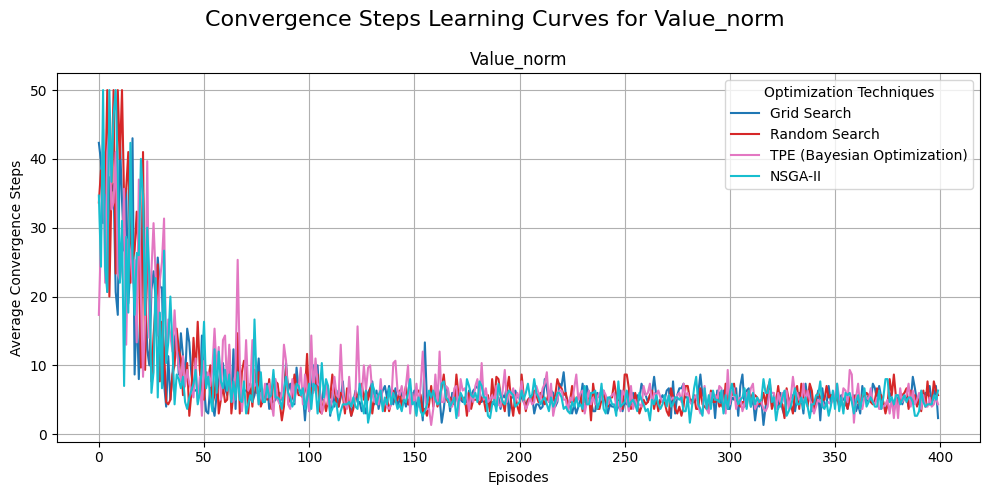

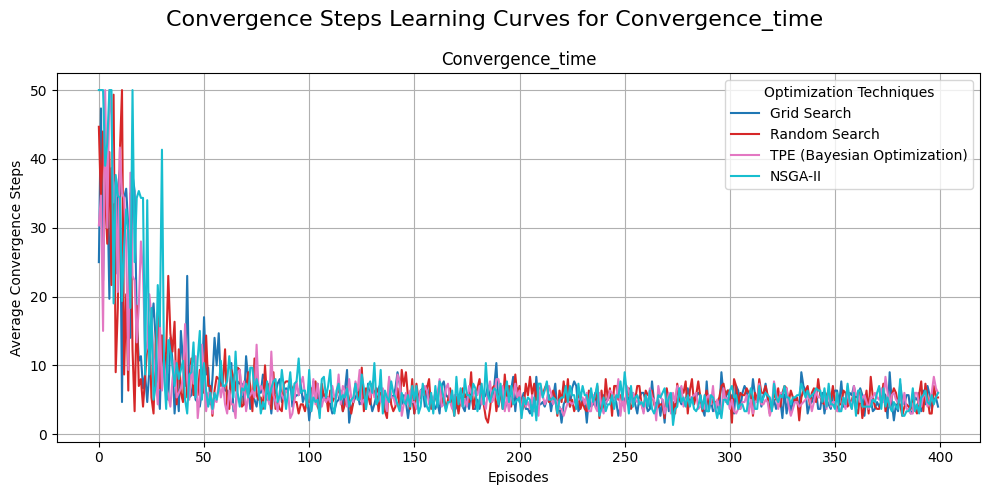

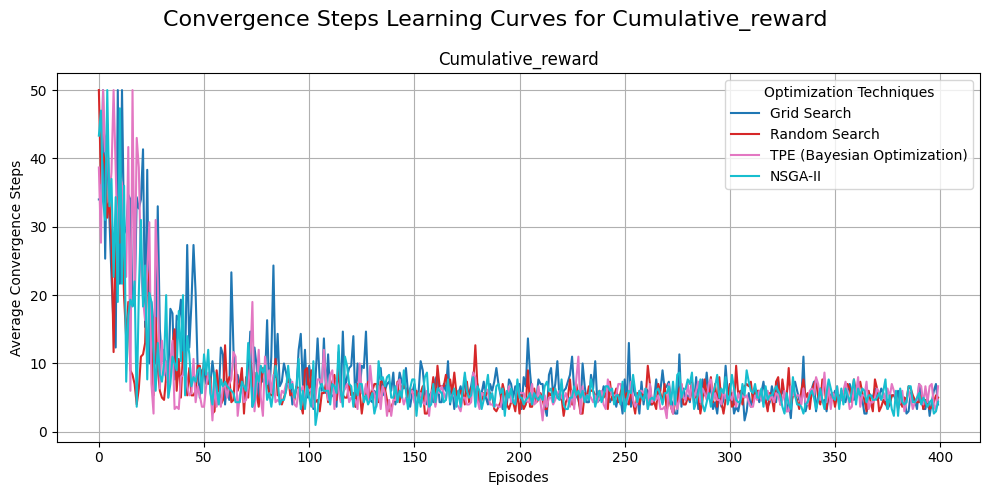

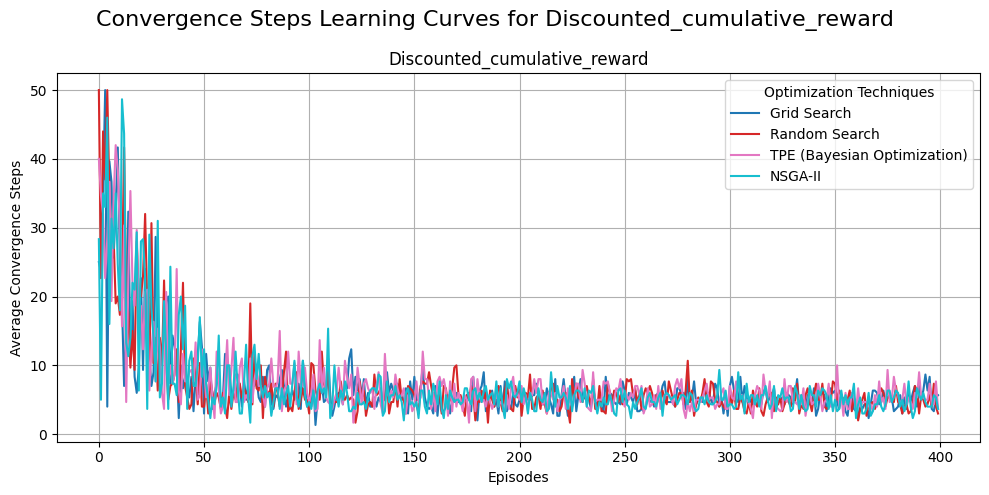

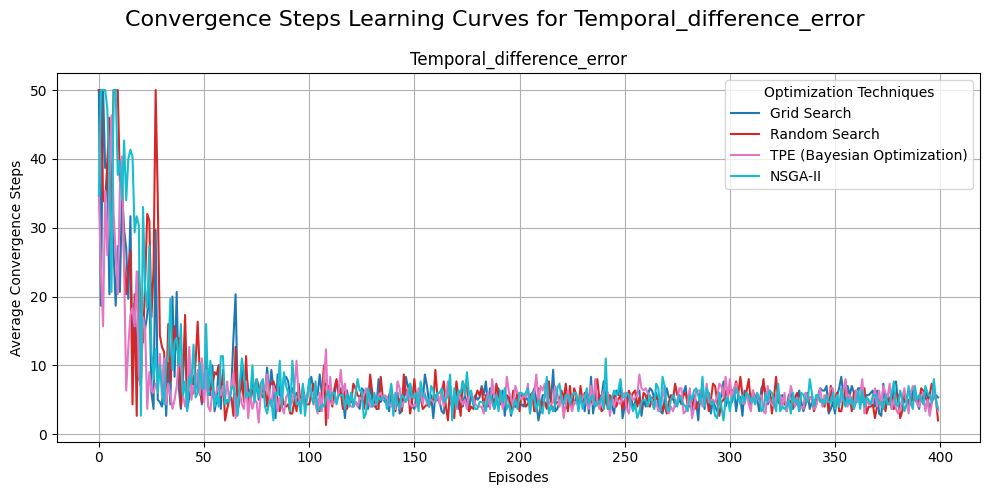

In [14]:
%matplotlib inline
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Convergence Steps", compute_convergence_steps)


### Mean Values Learing Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


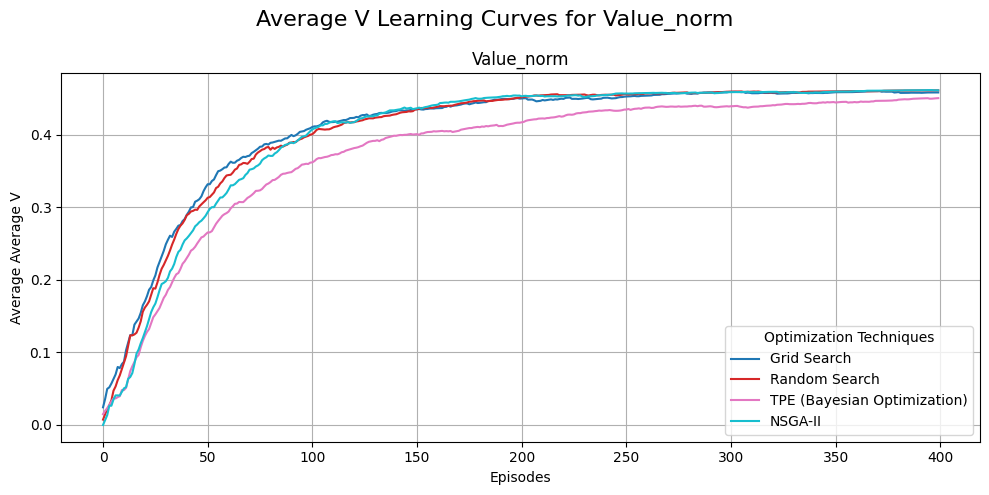

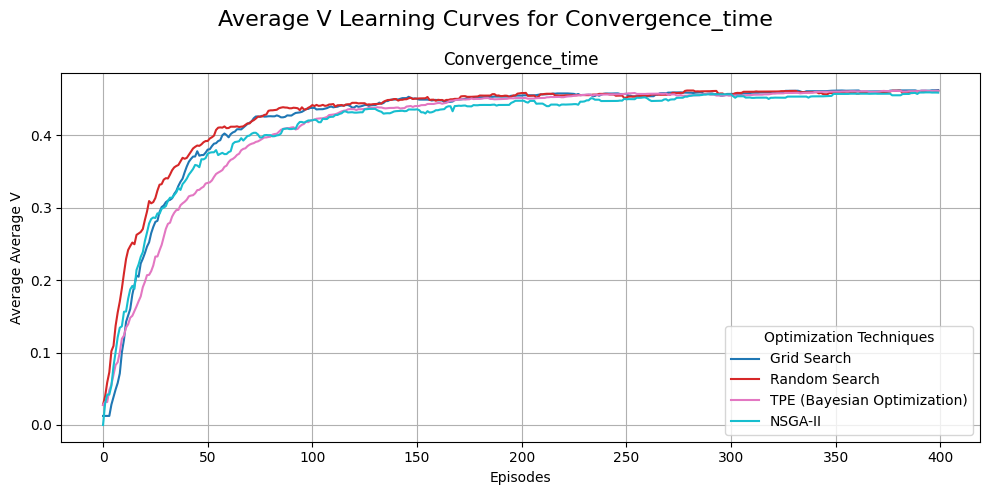

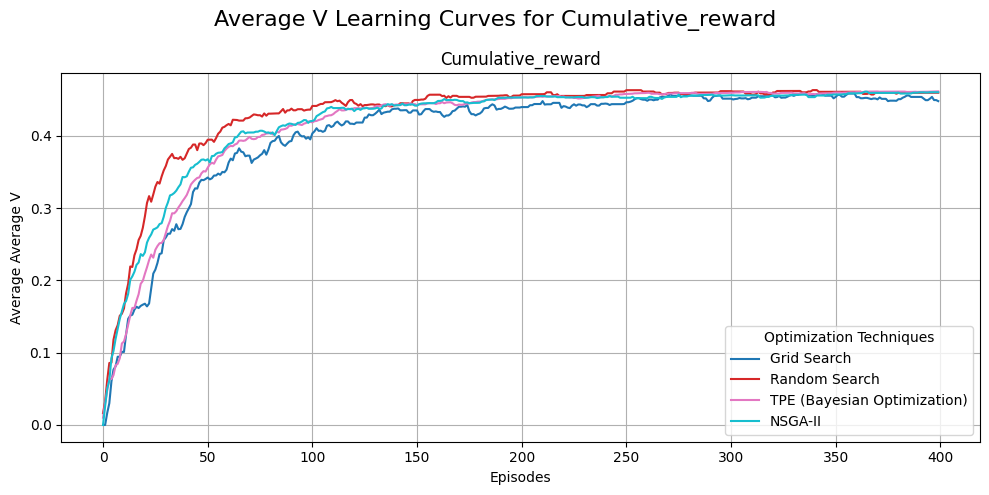

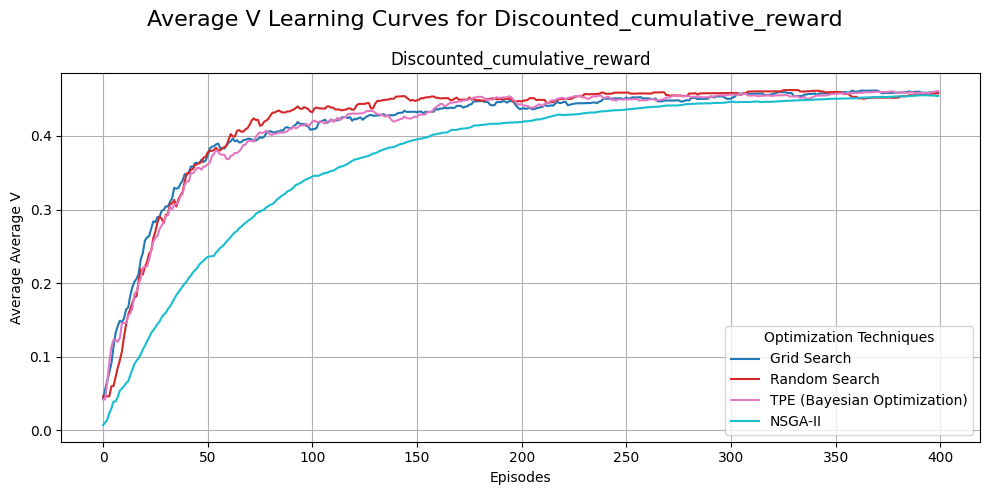

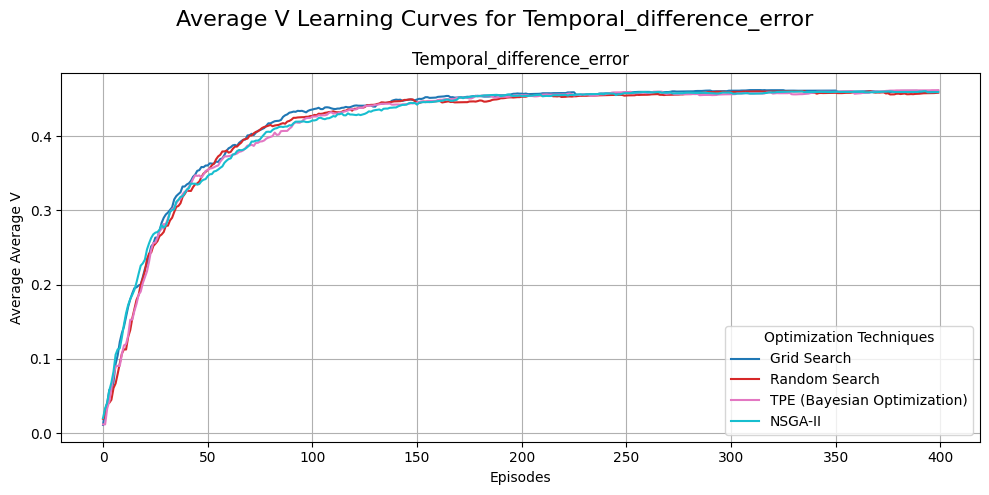

In [15]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Average V", compute_avg_values)


### Rewards Learning Curves

/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


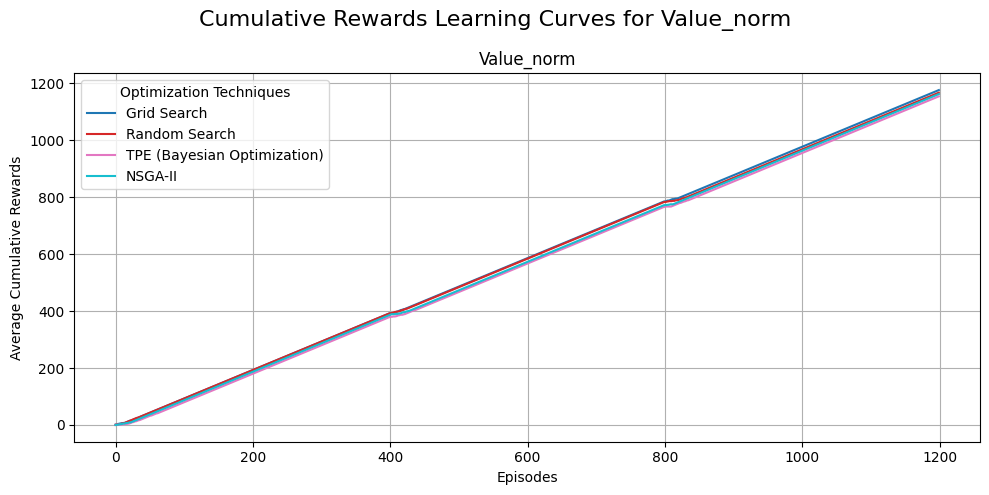

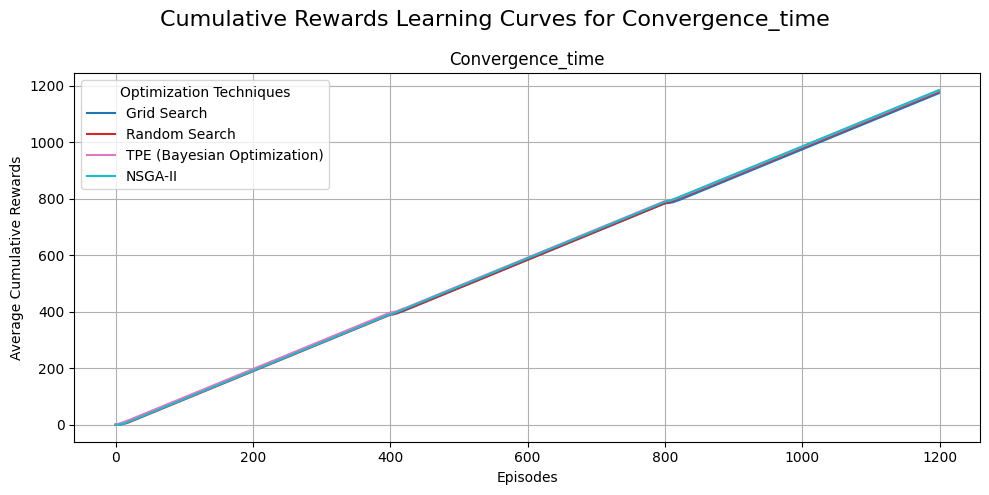

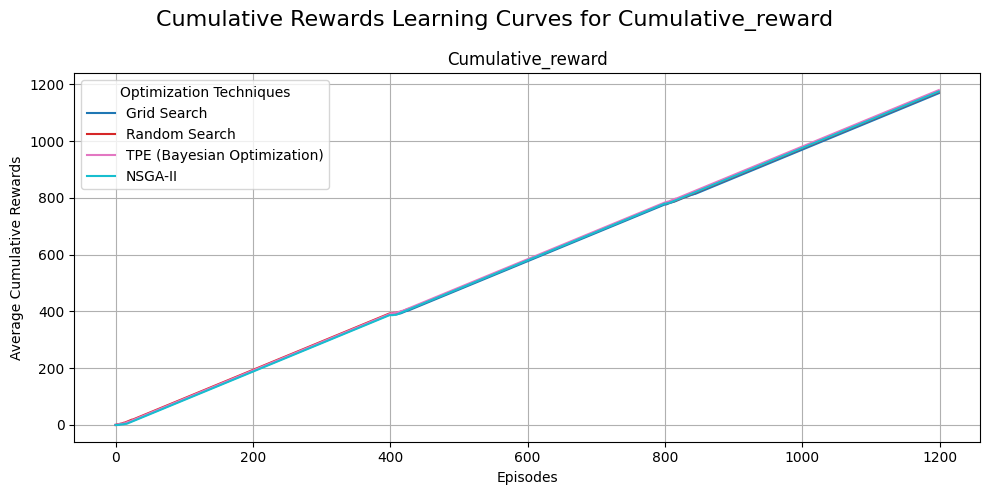

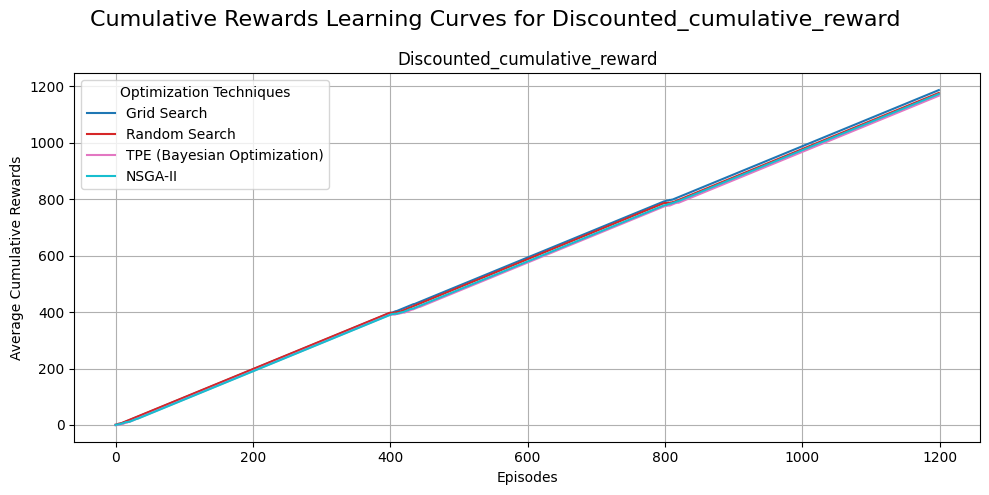

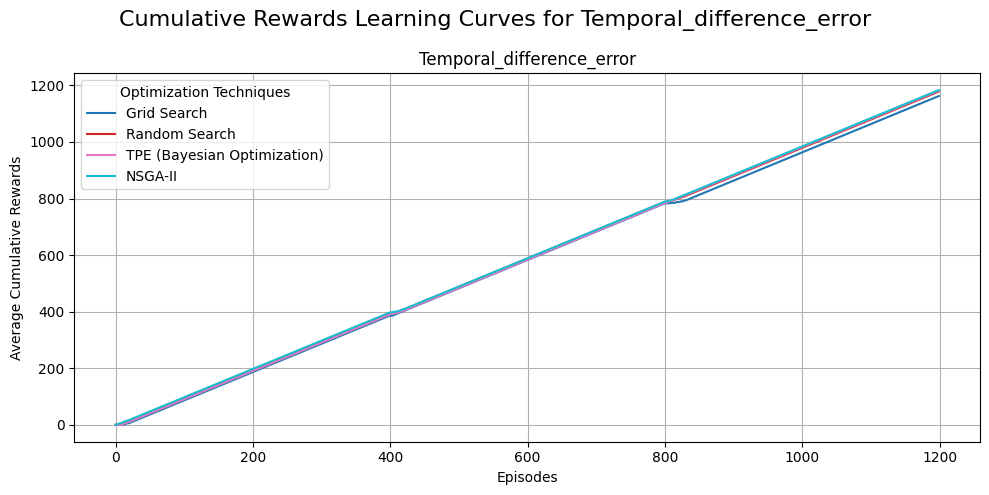

In [16]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Cumulative Rewards", compute_cumulative_rewards)


/tmp/ipykernel_259752/3896110873.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(SAMPLERS))  # Utilise une palette de 10 couleurs


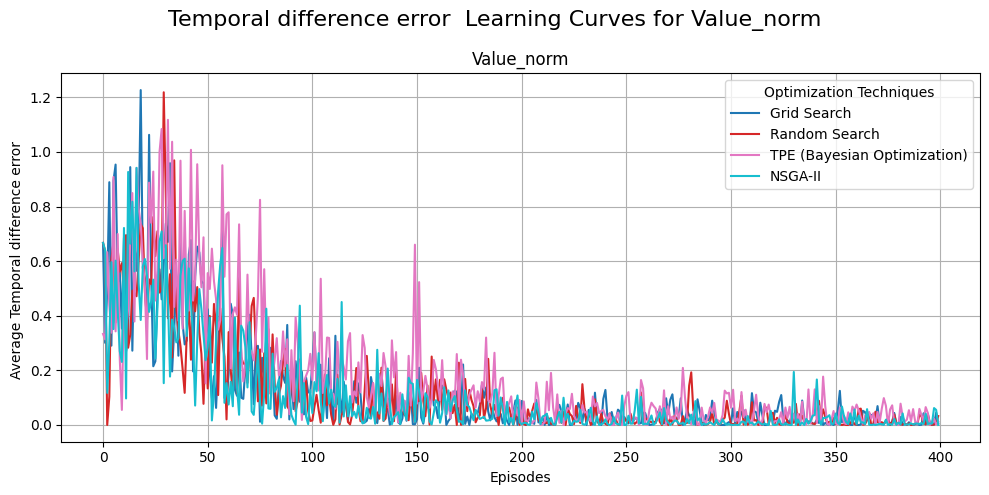

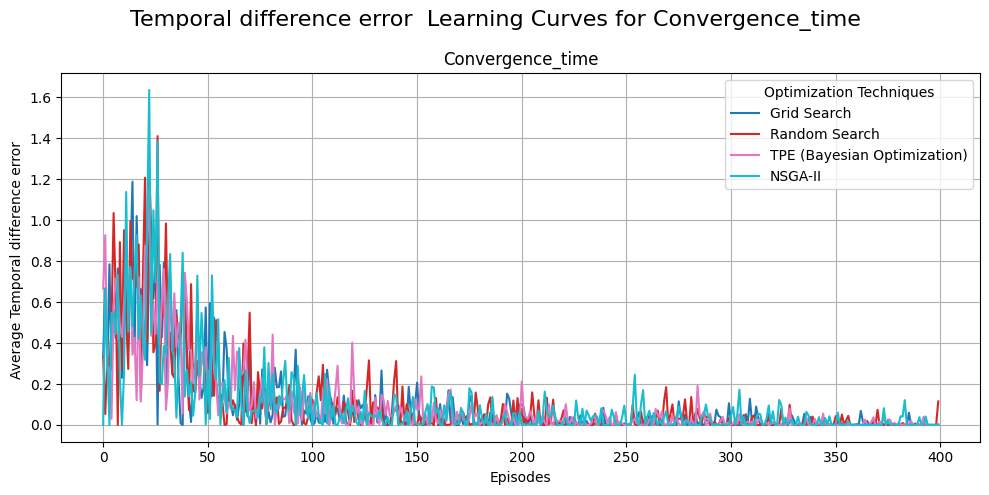

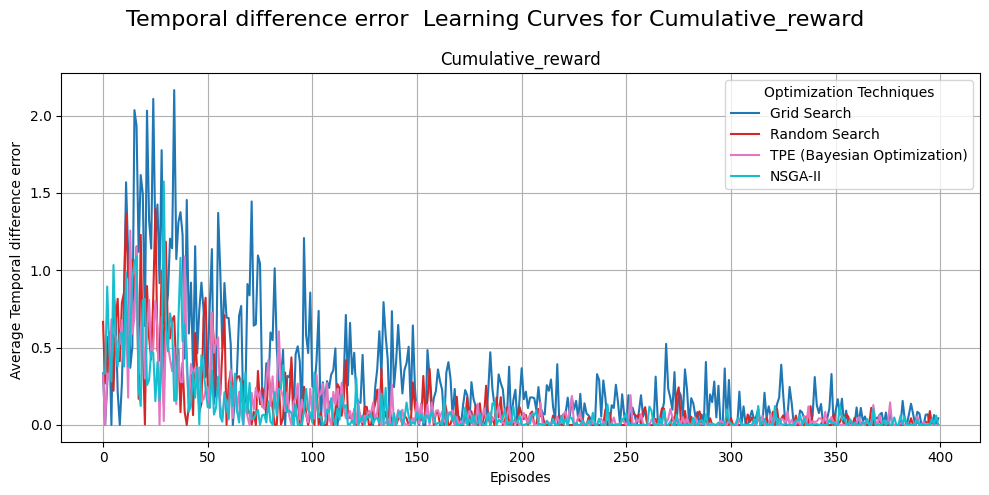

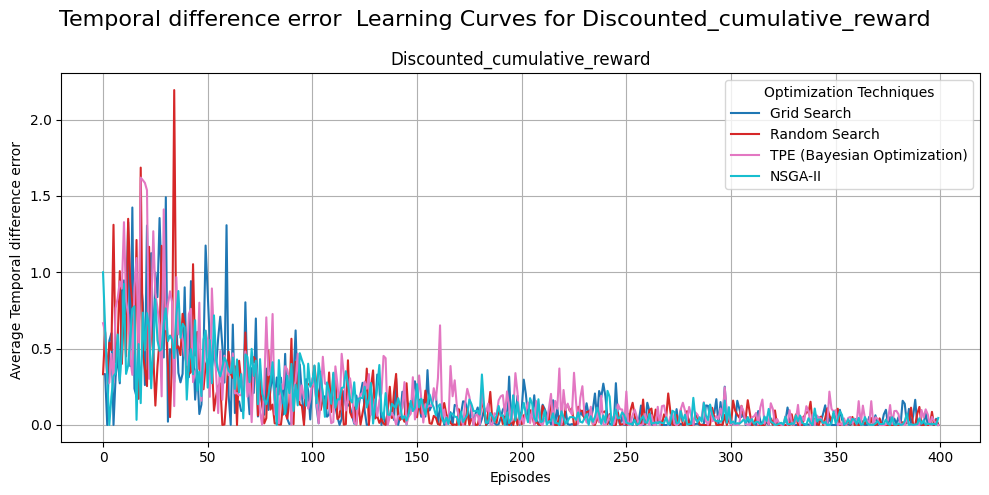

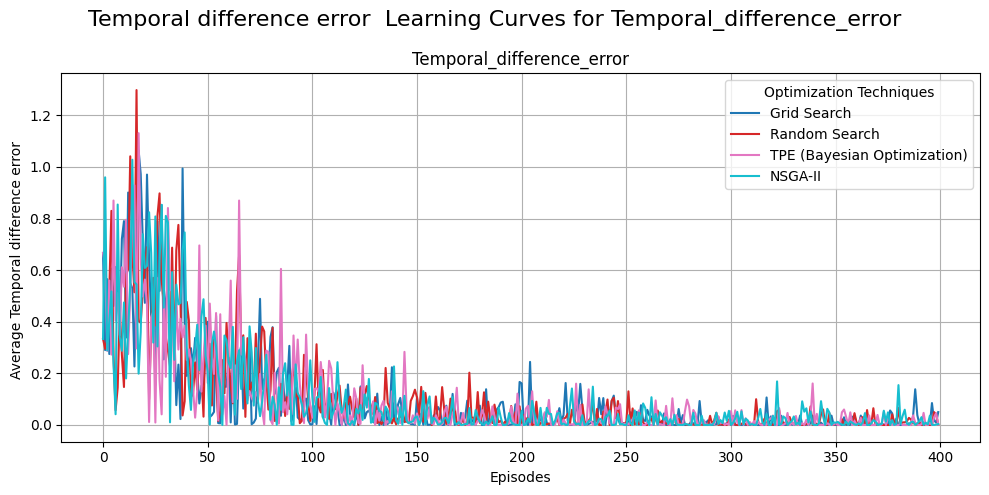

In [17]:
plot_metric_per_criterion(criteria, results, n_runs, env, AC_PARAMS, "Temporal difference error ", compute_deltas)


## The heat maps

### Value norms

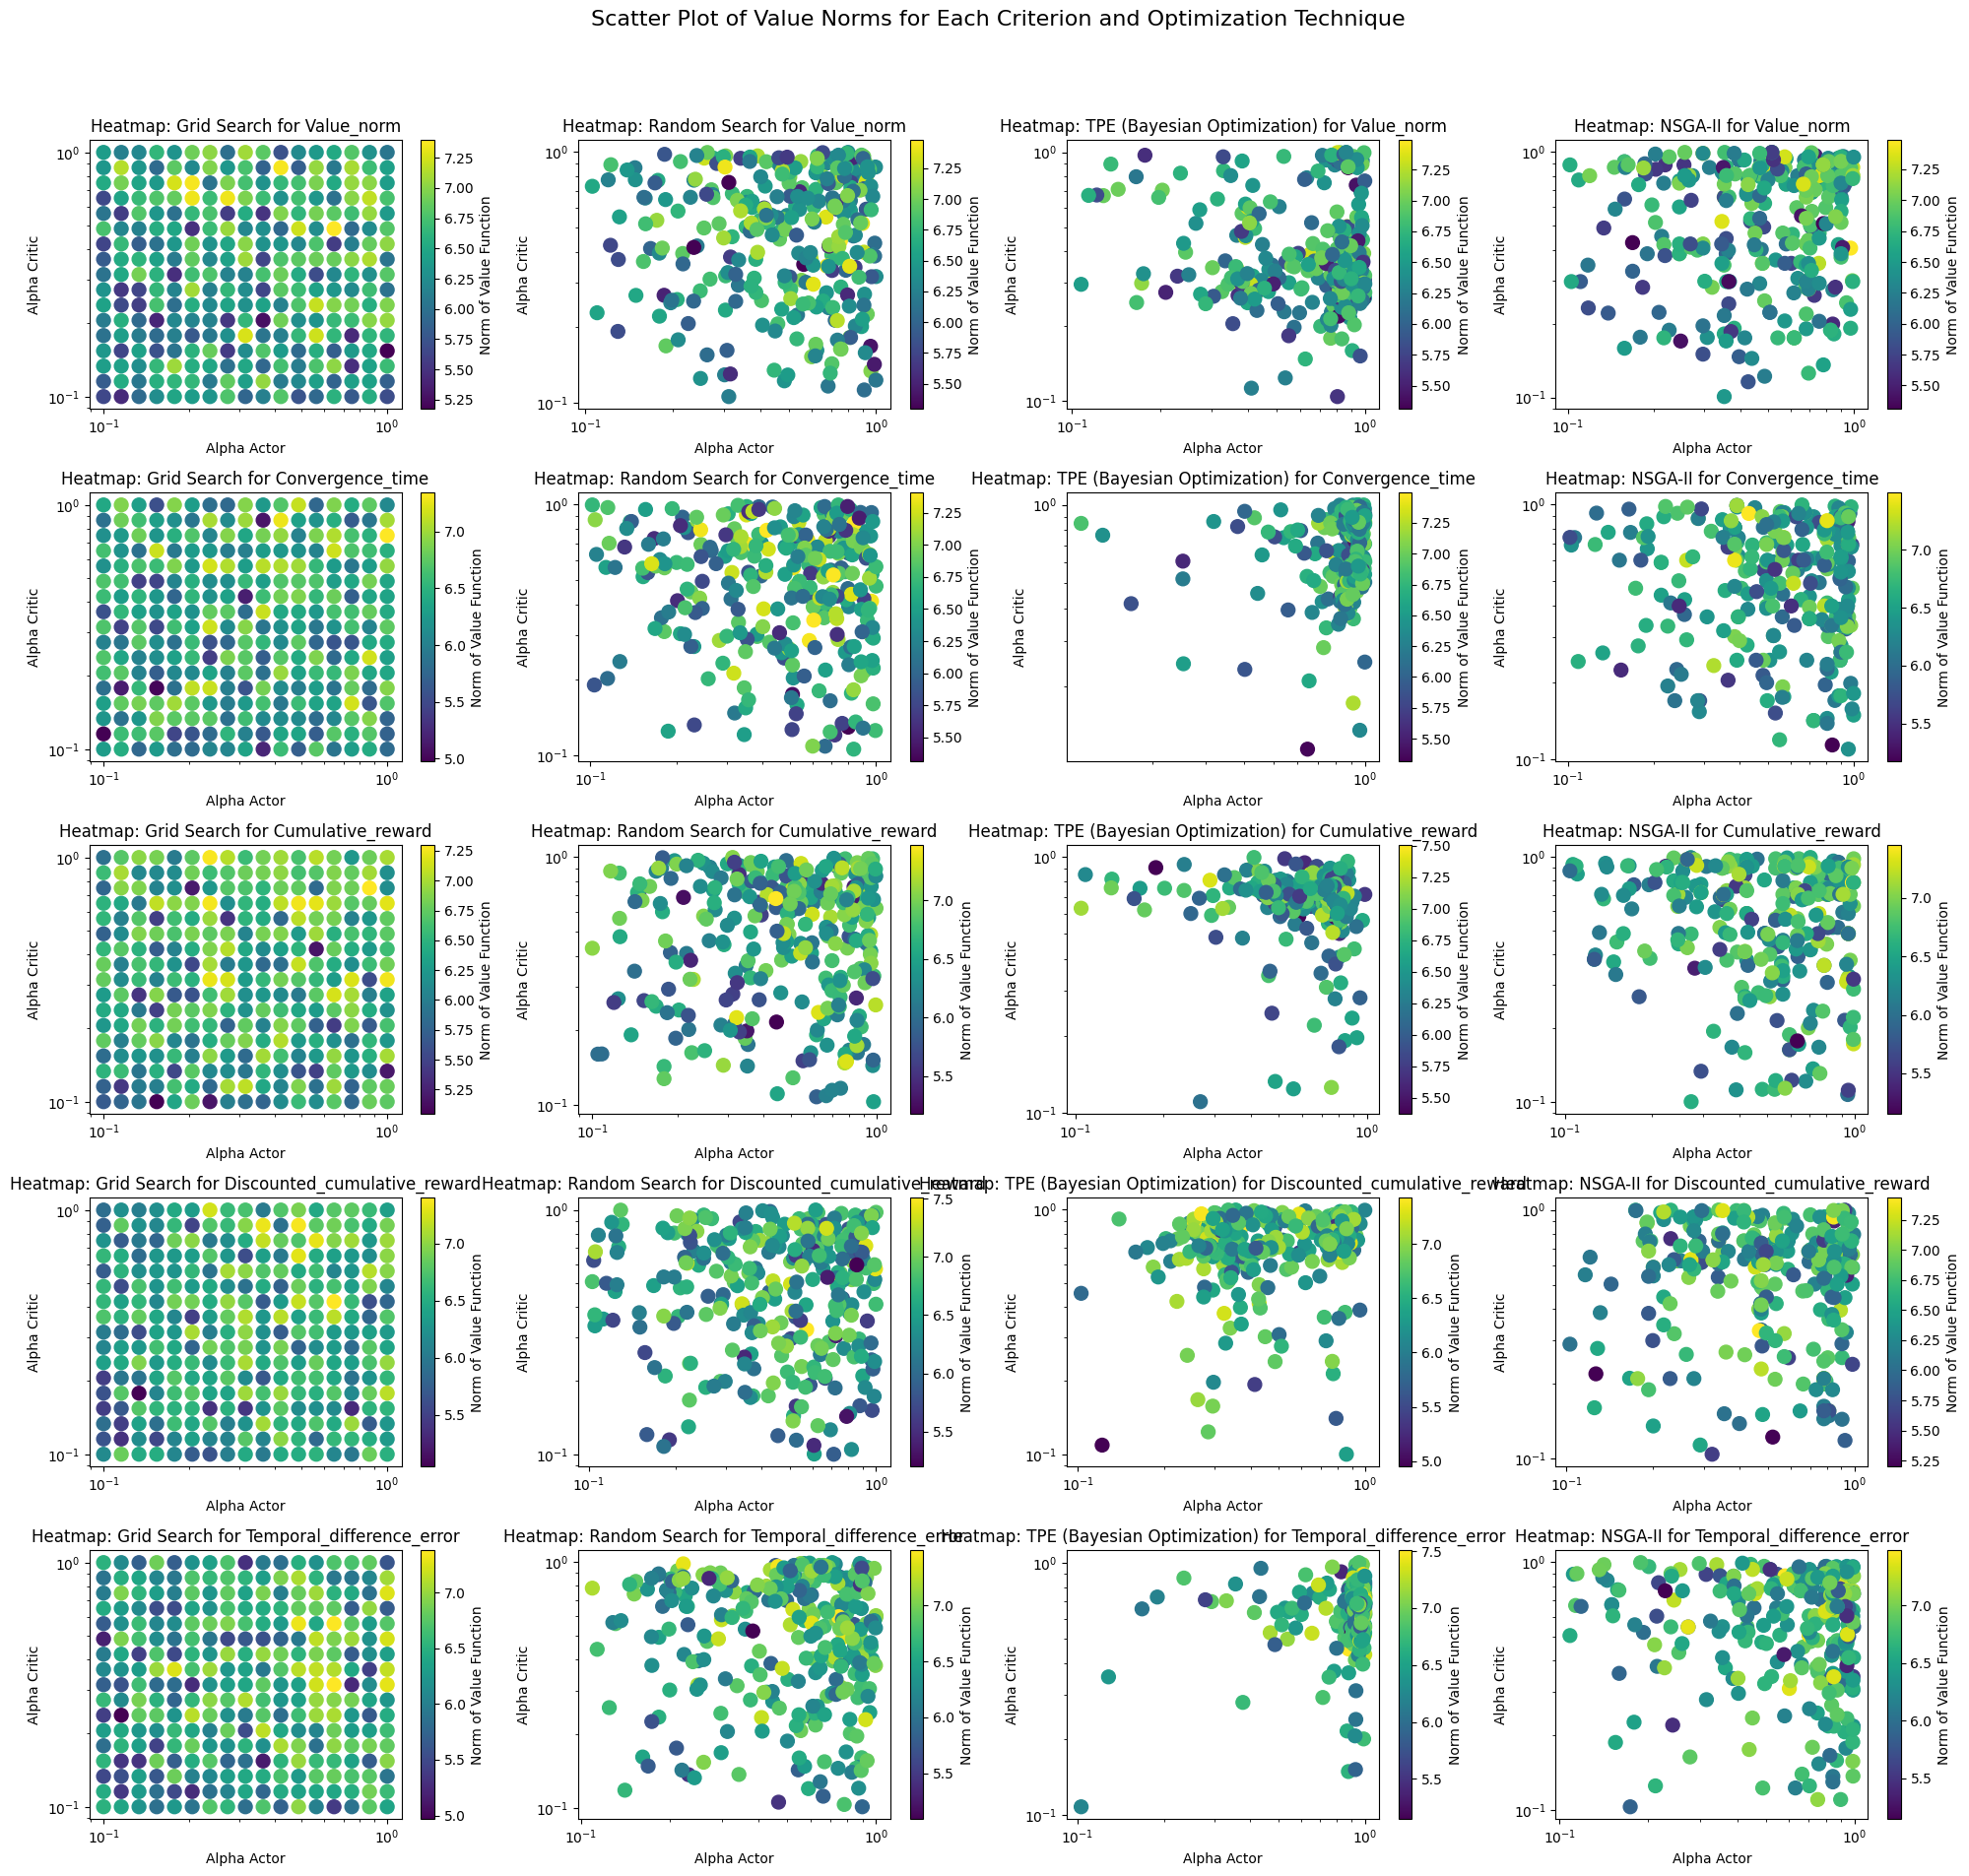

In [18]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Value Norms for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding value norms
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        value_norms = result['value_norms']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=value_norms, cmap='viridis', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Heatmap: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the value norms
        fig.colorbar(scatter, ax=ax, label='Norm of Value Function')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### The Cumulative Rewards

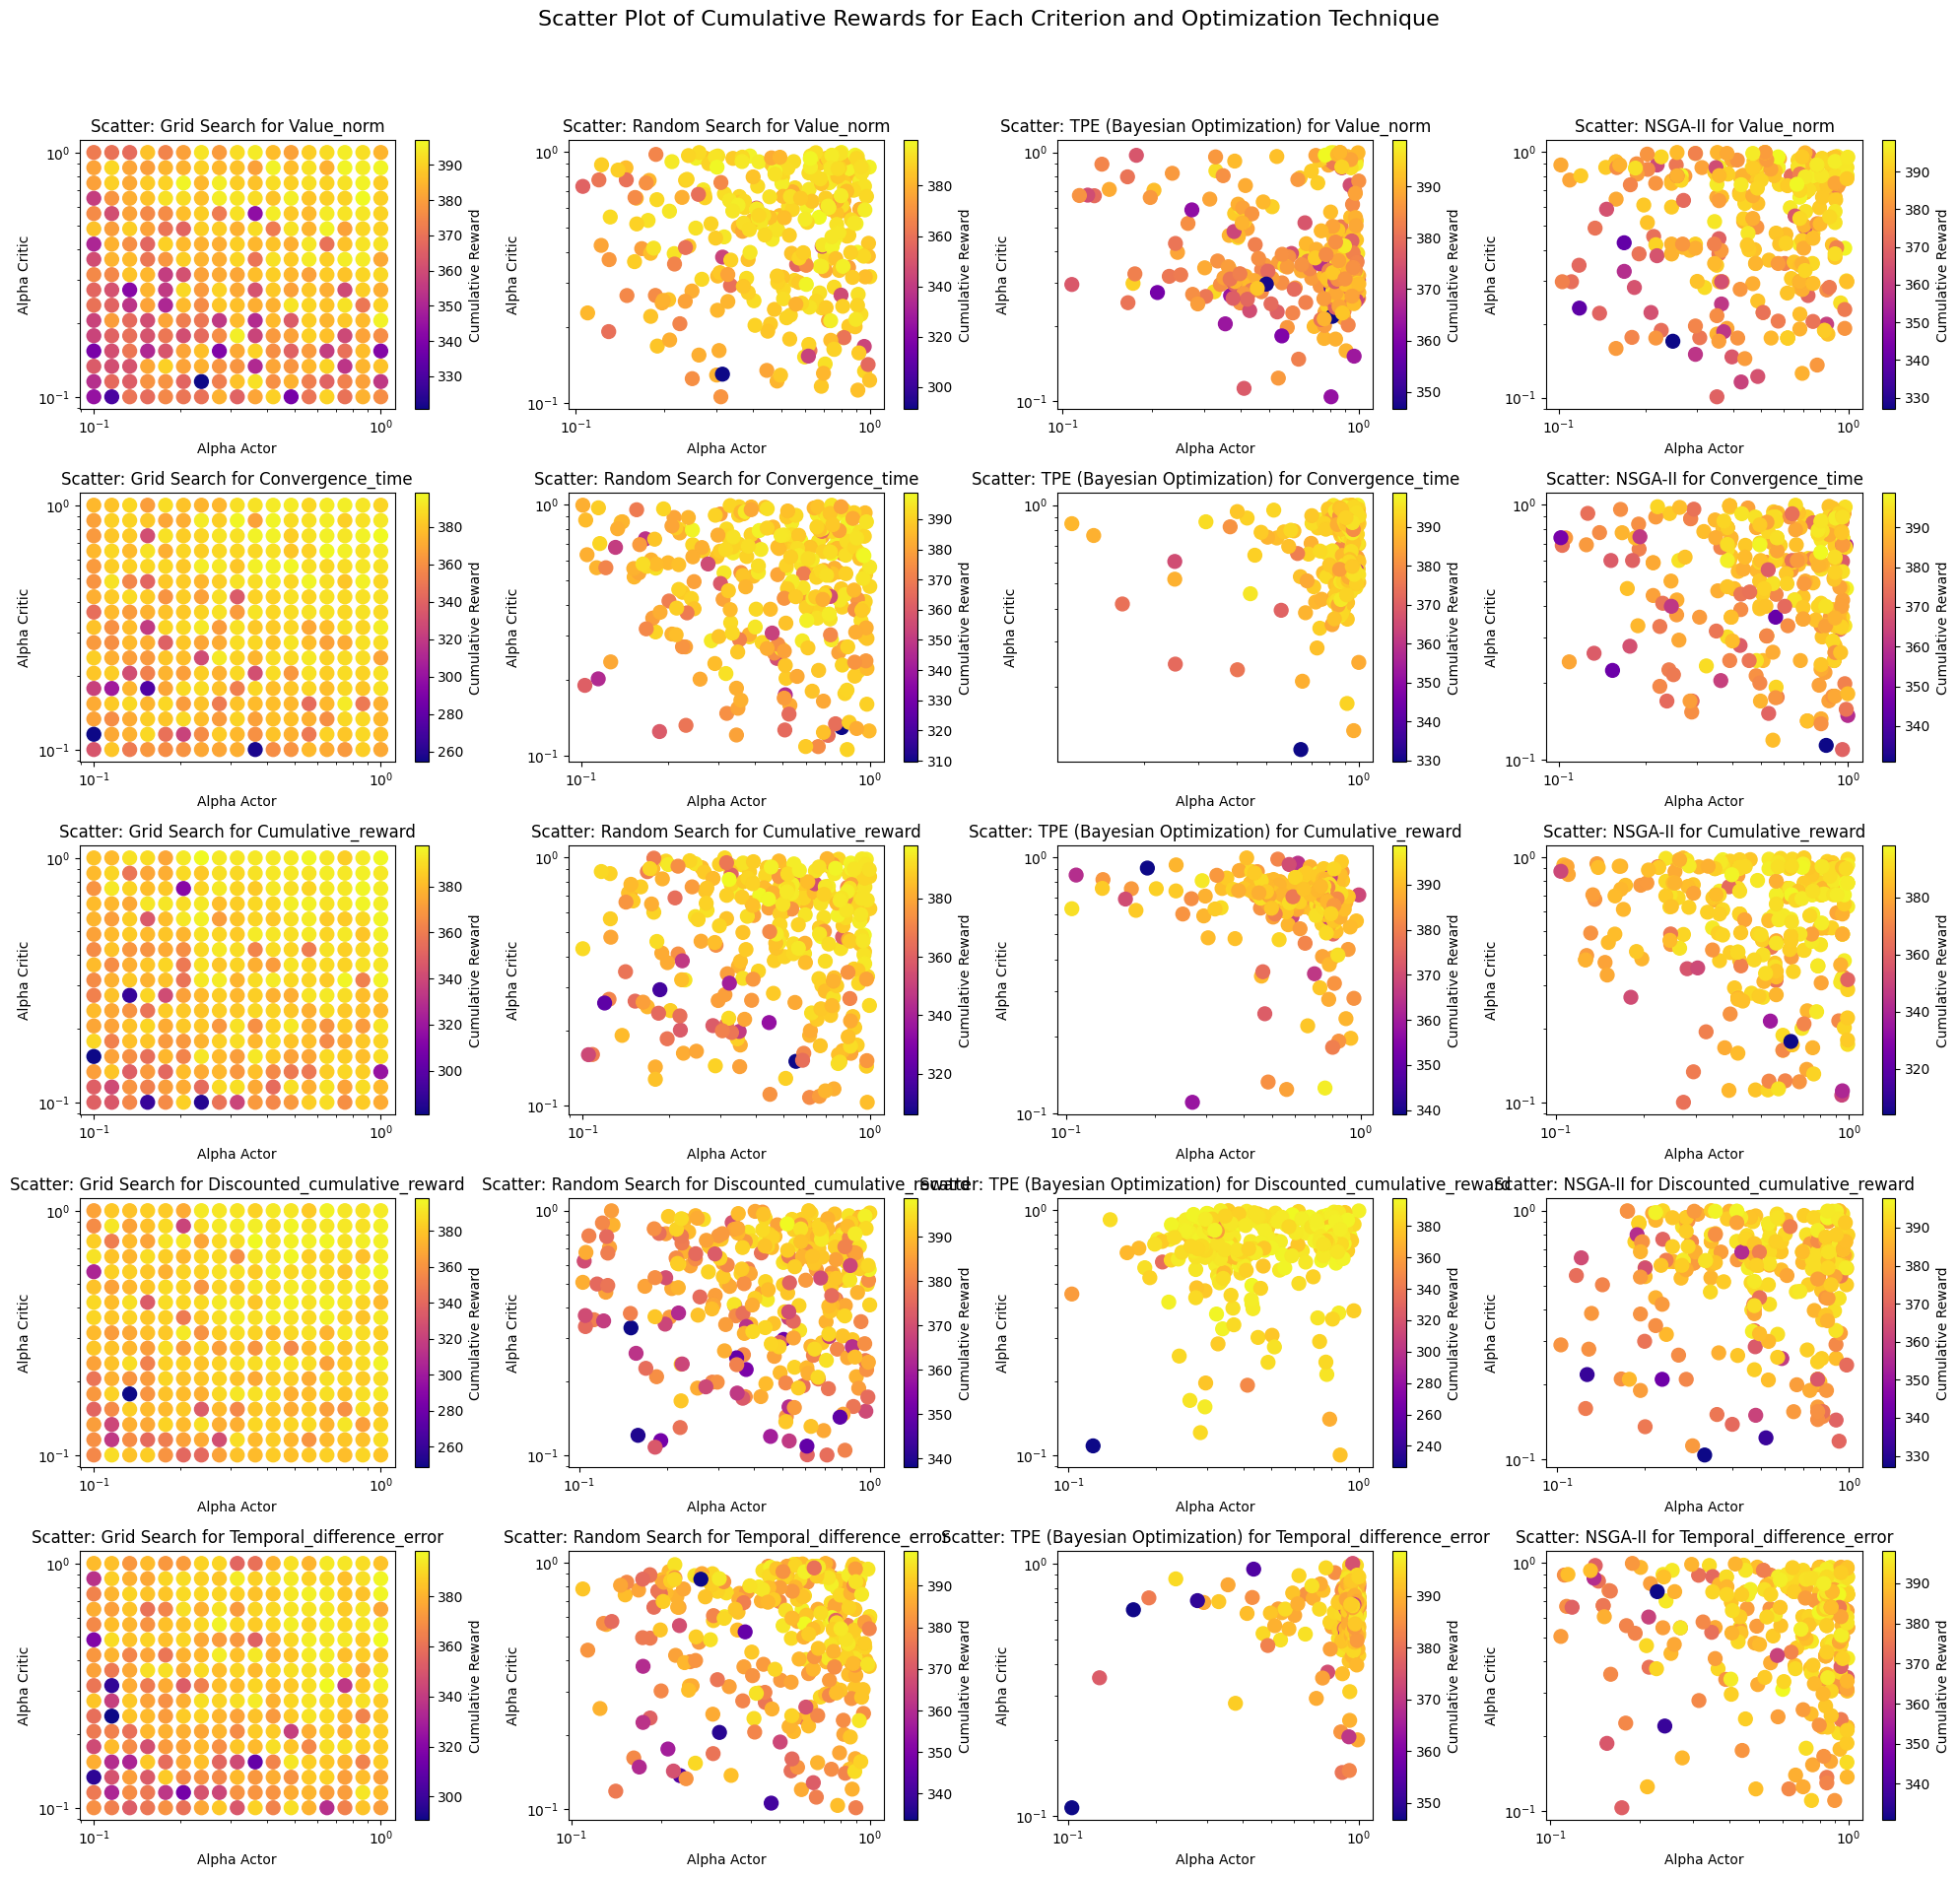

In [19]:
# Number of rows and columns for the grid of scatter plots
n_rows = len(criteria)  # Each row corresponds to a criterion
n_cols = len(SAMPLERS)  # Each column corresponds to an optimization technique

# Create a grid of subplots for the scatter plots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
fig.suptitle("Scatter Plot of Cumulative Rewards for Each Criterion and Optimization Technique", fontsize=16)

# Iterate through each criterion (rows)
for i, criterion in enumerate(criteria):
    # Iterate through each sampler (columns)
    for j, sampler_name in enumerate(SAMPLERS.keys()):
        # Get the result key for the current criterion and sampler
        result_key = f"{criterion}_{sampler_name}"
        result = results.get(result_key)

        if result is None:
            continue  # Skip if there is no result for this combination

        # Extract the hyperparameter values and corresponding cumulative rewards
        alpha_actor_vals = [params[0] for params in result['all_params']]
        alpha_critic_vals = [params[1] for params in result['all_params']]
        cumulative_rewards = result['cumulative_rewards']

        # Select the correct subplot (axs is a grid)
        ax = axs[i, j]

        # Create the scatter plot for cumulative rewards
        scatter = ax.scatter(alpha_actor_vals, alpha_critic_vals, c=cumulative_rewards, cmap='plasma', s=100)

        # Set logarithmic scale for both axes
        ax.set_xscale('log')
        ax.set_yscale('log')

        # Add labels and titles
        ax.set_xlabel("Alpha Actor")
        ax.set_ylabel("Alpha Critic")
        ax.set_title(f"Scatter: {sampler_name} for {criterion.capitalize()}")

        # Add a colorbar for each plot to represent the cumulative rewards
        fig.colorbar(scatter, ax=ax, label='Cumulative Reward')

# Adjust layout to ensure the plots are spaced properly
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


# Step 3: Statistical tests

# Tests

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc..